# Week 6: Logistic Regression

## **Notebook Overview**

This notebook is available on github
[here](https://github.com/Yushi-Y/AAS-ongoing-tutorials). If you find errors or would like to suggest an improvement then let me know.

This week is about logistic regression. This is probably going to be a very popular topic for the summative so worth going through this notebook in full. Since it is such a popular topic, there are also loads of extra resources available for you to look at.

It is mostly all on binary logistic regression but there is also one question which asks you to do a multinomial logistic regression.

### **Additional Resources**

1. **[Useful Ben Lambert Videos:](https://www.youtube.com/playlist?list=PLwJRxp3blEvb7P-7po9AxuBwquPv75LjU)** We're on to content in part 2 of his full undergradute course. I have just linked the main ones but are loads more videos on these topics. I haven't included the introduction to maximum likelihood videos as I assume that people who are interested will have come across the topic before - if not then there are lots of others in the playlist on YouTube.

  **Level 1: Strongly recommend**
      * [Linear Probability Model](https://www.youtube.com/watch?v=RY31VsA67Uc). Introduction to the LPM as well as another video with an [example](https://www.youtube.com/watch?v=gFQo1Rttj6M). The problems with the LPM: [Part 1](https://www.youtube.com/watch?v=Q0BH-5OGwBc&list=PLwJRxp3blEvb7P-7po9AxuBwquPv75LjU&index=32&pp=iAQB), [Part 2](https://www.youtube.com/watch?v=pgPhbVEbYqw&list=PLwJRxp3blEvb7P-7po9AxuBwquPv75LjU&index=33&pp=iAQB) and [Part 3](https://www.youtube.com/watch?v=pxQ8fs8w69M&list=PLwJRxp3blEvb7P-7po9AxuBwquPv75LjU&index=34&pp=iAQB).
      * [Motivation for Non-Linear Discrete Choice Models](https://www.youtube.com/watch?v=8aUTmFs_LcQ&list=PLwJRxp3blEvb7P-7po9AxuBwquPv75LjU&index=35&pp=iAQB) and  [Introduction to Discrete Choice Models](https://www.youtube.com/watch?v=yPCQZeGWJjw). Very basics of discrete choice. Covers logit and probit - you really only need to know logit for this course.
      
  **Level 2: Good to know**
      * [Partial Effects in Discrete Choice Models](https://www.youtube.com/watch?v=-9SlfOHCguk&list=PLwJRxp3blEvb7P-7po9AxuBwquPv75LjU&index=37&pp=iAQB). Also a [part 2](https://www.youtube.com/watch?v=1kqb2K6Zmpc&list=PLwJRxp3blEvb7P-7po9AxuBwquPv75LjU&index=38&pp=iAQB).

  **Level 3: If time**
      * [Maximum Likelihood Estimation of Coefficienties](https://www.youtube.com/watch?v=WflqTUOvdik): Covers both logit and probit models again but the intuition is there.
      * [Likelihood Ratio Test](https://www.youtube.com/watch?v=Tn5y2i_MqQ8&list=PLwJRxp3blEvb7P-7po9AxuBwquPv75LjU&index=46&pp=iAQB)

2. **Documentation:** See the statsmodels page on [statsmodels.formula.api.logit](https://www.statsmodels.org/dev/generated/statsmodels.formula.api.logit.html) and on [statsmodels.formula.api.mnlogit](https://www.statsmodels.org/dev/generated/statsmodels.formula.api.mnlogit.html). Logit and multinomial logit.

4. **[Wooldridge Econometrics:](https://www.academia.edu/44467534/ECONOMETRICS_A_Modern_Approach)** Topics are covered extensively.

5. **Fox Textbook:** **[Good resource for really understanding the mathematical theory in depth]** Topics are covered extensively.


As usual we will start by importing some useful libraries.

In [ ]:
%config InlineBackend.figure_format = 'svg'
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In this notebook we will look at data on the mode of travel chosen by people
travelling between Sydney and Melbourne (Australia). Relevant variables for us
in this dataset are the mode of travel chosen: air, bus, car or train, the
travel time, the generalised cost of the journey, the income of the household
travelling, and the number of people travelling together. The relevant dataset
is provided by the `statsmodels` package.

In [ ]:
# Read in the data
travel_dataset = sm.datasets.get_rdataset("TravelMode", "AER")
travel_df = travel_dataset.data

#print(travel_dataset.__doc__) # Uncomment to have a look at the documentation for the dataset

### Question 1

What units is the variable `income` in? Note that this isn't in the meta data but use the other information to make a reasonable guess.

### Answer

Although it doesn't state it explicitly in the meta-data, it appears this is a
measure of income in thousands of Australian dollars. This can be guessed
because is on the order of the national average, although as a dataset from
1997, it is getting a bit old.

## **Data exploration**

As a first pass we will look at modelling whether the selected mode was train or
car. The following snippet puts the data in a tidy format. Note we have added a
new variable, `is_car`, which is `1` if the travel was done by car and `0` if it
was done by train. We will also subset the data to only contain those records
where the travellers had a choice in the mode of transport.

In general, it is not a great idea to systematically throw away data, but for purposes of demonstrating binary logistic regression we will do it here.

In [ ]:
# Create a new df only containing those who travelled by train or car and had a choice
cb_df = travel_df[(travel_df["mode"] == "train") | (travel_df["mode"] == "car")]
cb_df = cb_df[cb_df["choice"] == "yes"]

# Restrict the df to only consider two features and rename
cb_df = cb_df[["mode", "income", "size"]]
cb_df = cb_df.rename(columns={"mode": "vehicle", "size": "num_people"})

# Separate the regressors
predictor_names = ["income", "num_people"]

# Generate an output variable which is 1 if vehicle is equal to car and 0 if not
cb_df["is_car"] = 0
cb_df.loc[cb_df["vehicle"] == "car","is_car"] = 1

print(cb_df.head(10))

   vehicle  income  num_people  is_car
3      car      35           1       1
7      car      30           2       1
11     car      40           1       1
15     car      70           3       1
19     car      45           2       1
21   train      20           1       0
31     car      12           1       1
35     car      40           1       1
39     car      70           2       1
43     car      15           2       1


### Question 2

Generate visualisations to see how the distribution of income among car and
train trips. What do you notice?

[hint](https://aezarebski.github.io/misc/matplotlib/gallery.html#fig-06)

The boxplots below show journeys by car are more likely to have individuals from
households with a larger income and transport more people.

In [ ]:
print(cb_df.shape)
#cb_df.head(20)
unique_vehicles = cb_df.vehicle.unique()
grouped_values = {p : [cb_df[cb_df.vehicle == v][p] for v in unique_vehicles] for p in predictor_names}

(122, 4)


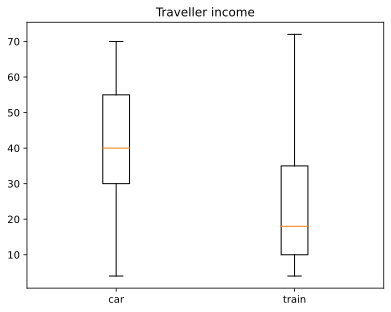

In [ ]:
plt.figure()
plt.boxplot(x = grouped_values["income"],
           labels = unique_vehicles)
plt.title("Traveller income")
plt.show()

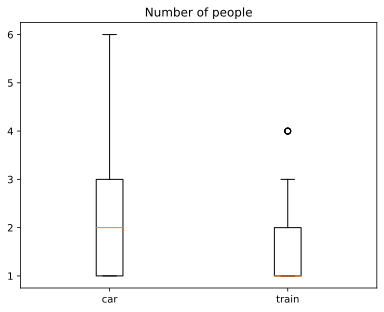

In [ ]:
plt.figure()
plt.boxplot(x = grouped_values["num_people"],
           labels = unique_vehicles)
plt.title("Number of people")
plt.show()

## **Logistic Model**

### Question 3

Fit a logistic regression model to this data. Do the estimated coefficients make
sense?

[hint](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.logit.html#statsmodels.formula.api.logit)

### Answer

We can use the `logit` function from `smf` to fit the logistic regression.

In [ ]:
logistic_model = smf.logit(formula="is_car ~ income + num_people", data = cb_df).fit()

Optimization terminated successfully.
         Current function value: 0.560467
         Iterations 6


In [ ]:
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 is_car   No. Observations:                  122
Model:                          Logit   Df Residuals:                      119
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                  0.1908
Time:                        16:57:58   Log-Likelihood:                -68.377
converged:                       True   LL-Null:                       -84.498
Covariance Type:            nonrobust   LLR p-value:                 9.968e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2289      0.523     -4.263      0.000      -3.254      -1.204
income         0.0566      0.013      4.399      0.000       0.031       0.082
num_people     0.1885      0.201      0.936      0.349      -0.206       0.583
==============================================================================
"""

Think about why it lists the number of iterations? When we ran OLS regression it didn't do that? What does it do that for logistic regression?

### Question 4

Write a function called `logit` which computes the logit function and
`inv_logit` which computes its inverse.

[hint](https://en.wikipedia.org/wiki/Logit#Definition)

In [ ]:
def logit(p):
    return np.log(p / (1 - p))

def inv_logit(a):
    return np.exp(a) / (np.exp(a) + 1)

The following snippet demonstrates one way to visualise the results of the model
fit. If you have defined `logistic_model`, `logit` and `inv_logit` above this should make a
sensible figure.

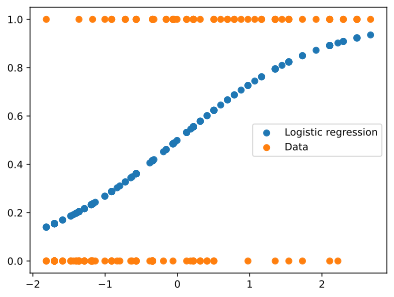

In [ ]:
# Displaying results as a plot
prob_is_car = logistic_model.predict()
log_odds_is_car = logit(prob_is_car)

plt.figure()
plt.scatter(log_odds_is_car, prob_is_car, label="Logistic regression")
plt.scatter(log_odds_is_car, cb_df["is_car"], label = "Data")
plt.legend()
plt.show()

### Question 5

For a fixed income, what change does the model predict for each additional
person on the journey? What happens to the log-odds for each additional person?
What happens to the odds?

### Answer



$$
\ln\left(\frac{p}{1-p}\right) = -2.2 + 0.06 \times \text{income} + 0.19 \times\text{num_people}
$$

For each additional person the *log-odds* of going by car increases by 0.19.

$$
\frac{p}{1-p} = e^{-2.2} (e^{0.06})^{\text{income}} + (e^{0.19})^{\text{num_people}}
$$

For each additional person the *odds* of going by car increase but the change is
not as simple as in the case of the log-odds.


### Question 6

For journeys with 2 people, plot the probability of going by car (as opposed to
train) as a function of household income. Determine the level of income at which
it becomes more likely they will travel by car than train.

### Answer

We can evaluate the predicted probability at a range of income levels and then
read off the plot that this changes at about 32.7 thousand, or we can just solve
for this value using the expression in the snippet.

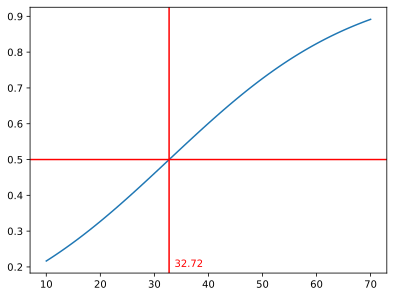

In [ ]:
income_change_point = (2.23 - 0.189 * 2) / 0.0566
income_vals = np.linspace(10, 70, 100)

theta_int = logistic_model.params.Intercept
theta_income = logistic_model.params.income
theta_num = logistic_model.params.num_people

prob_car = inv_logit(theta_int + theta_income * income_vals + theta_num * 2)

plt.figure()
plt.plot(income_vals, prob_car)
plt.axhline(0.5, color='r')
plt.axvline(income_change_point, color='r')
plt.annotate("{x:.2f}".format(x=income_change_point), (income_change_point + 1, 0.2), color='r')
plt.show()

### Question 7

Plot the probability of going by car for 1, 2, and 3 people as a function of
income. What do you notice about the change in the probability as a function of
income?

### Answer

The change in probability is non-linear and depends upon the other variables,
but it is increasing with the number of people.

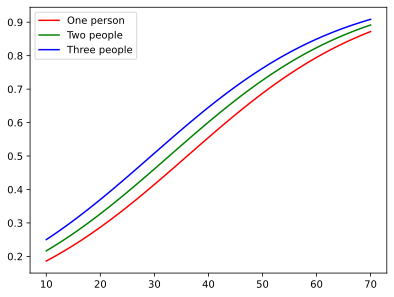

In [ ]:
income_vals = np.linspace(10, 70, 100)

theta_int = logistic_model.params.Intercept
theta_income = logistic_model.params.income
theta_num = logistic_model.params.num_people

prob_car_fn = lambda n : inv_logit(theta_int + theta_income * income_vals + theta_num * n)

plt.figure()
plt.plot(income_vals, prob_car_fn(1), color='r', label='One person')
plt.plot(income_vals, prob_car_fn(2), color='g', label='Two people')
plt.plot(income_vals, prob_car_fn(3), color='b', label='Three people')
plt.legend(loc='upper left')
plt.show()

## **Multinomial logistic regression**

### Question 8

Set up a multinomial logistic regression model to predict the mode of transport
used based on all of the data. Start afresh with the travel_df dataframe and built a multinomial regression. Only include those where choice was 'yes'.

In [ ]:
all_df = travel_df[travel_df["choice"] == "yes"]
all_df = all_df[["mode", "income", "size"]]
all_df = all_df.rename(columns={"mode": "vehicle", "size": "num_people"})

all_df["vehicle_int"] = 0
all_df.loc[all_df["vehicle"] == "air","vehicle_int"] = 1
all_df.loc[all_df["vehicle"] == "bus","vehicle_int"] = 2
all_df.loc[all_df["vehicle"] == "car","vehicle_int"] = 3
all_df.loc[all_df["vehicle"] == "train","vehicle_int"] = 4
all_df.vehicle.value_counts()

# Answers incomplete for now...
# if anyone has a particularly elegant answer with some nice analysis and graphs then send it to me and I'll make it the answer for evermore...

train    63
car      59
air      58
bus      30
Name: vehicle, dtype: int64